# TweetyCLR on Nerve Transection Data

This is an analysis of canary nerve transection data collected by Rose Hulsey Vincent, Melissa Bemrose, and Ellen Sova. This notebook is an analysis on 20 sonograms from a pre-transection day. 

Clone the repository

In [ ]:
!git clone https://github.com/ak1376/TweetyCLR.git
!pip install umap-learn

Import the necessary packages

In [1]:
import numpy as np
import torch
import sys
filepath = '/Users/AnanyaKapoor'
import os
os.chdir('/Users/AnanyaKapoor/Downloads/TweetyCLR')
# os.chdir('/Users/AnanyaKapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/TweetyCLR_End_to_End')
from util import MetricMonitor, SupConLoss
from util import Tweetyclr, Temporal_Augmentation, TwoCropTransform, Custom_Contrastive_Dataset
import torch.nn as nn
import torch.nn.functional as F
import os
import pickle
from torch.utils.data import DataLoader, TensorDataset
import umap
import matplotlib.pyplot as plt
import torch.optim as optim

plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = [15, 15]  # width and height should be in inches, e.g., [10, 6]


Define the convolutional frontend model for contrastive learning. This model does not include any pooling and does not have any fully connected layer after the convolutional blocks. 

In [2]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3,1,padding=1)
        self.conv2 = nn.Conv2d(8, 8, 3,2,padding=1)
        self.conv3 = nn.Conv2d(8, 16,3,1,padding=1)
        self.conv4 = nn.Conv2d(16,16,3,2,padding=1)
        self.conv5 = nn.Conv2d(16,24,3,1,padding=1)
        self.conv6 = nn.Conv2d(24,24,3,2,padding=1)
        self.conv7 = nn.Conv2d(24,32,3,1,padding=1)
        self.conv8 = nn.Conv2d(32,24,3,2,padding=1)
        self.conv9 = nn.Conv2d(24,24,3,1,padding=1)
        self.conv10 = nn.Conv2d(24,16,3,2,padding=1)

        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(8)
        self.bn3 = nn.BatchNorm2d(16)
        self.bn4 = nn.BatchNorm2d(16)
        self.bn5 = nn.BatchNorm2d(24)
        self.bn6 = nn.BatchNorm2d(24)
        self.bn7 = nn.BatchNorm2d(32)
        self.bn8 = nn.BatchNorm2d(24)
        self.bn9 = nn.BatchNorm2d(24)
        self.bn10 = nn.BatchNorm2d(16)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout2d(
        )

        self._to_linear = 320

    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = F.relu(self.bn9(self.conv9(x)))
        x = F.relu(self.bn10(self.conv10(x)))

        x = x.view(-1, 320)


        return x


The below function will perform the contrastive learning.

In [3]:
def pretraining(epoch, model, contrastive_loader, optimizer, criterion, method='SimCLR'):
    "Contrastive pre-training over an epoch. Adapted from XX"
    negative_similarities_for_epoch = []
    ntxent_positive_similarities_for_epoch = []
    mean_pos_cos_sim_for_epoch = []
    mean_ntxent_positive_similarities_for_epoch = []
    metric_monitor = MetricMonitor()
    model.train()

    # dummy_dataloader = contrastive_loader[0] # THis will be used for the indices to enumerate

    # Use a list comprehension to concatenate data tensors within each tuple along dimension 0
    # data =  [torch.cat([data for data, _ in data_loader], dim=0) for data_loader in contrastive_loader]

    # # Concatenate all the data tensors from the list into one tensor
    # data = torch.cat(data, dim=0)


    for batch_data in enumerate(contrastive_loader):
        data_list = []
        label_list = []
        a = batch_data[1]
        for idx in np.arange(len(a)):
            data_list.append(a[idx][0])

        data = torch.cat((data_list), dim = 0)
        data = data.unsqueeze(1)

        if torch.cuda.is_available():
            data = data.cuda()
        data = torch.autograd.Variable(data,False)
        bsz = a[idx][0].shape[0]
        data = data.to(torch.float32)
        features = model(data)
        norm = features.norm(p=2, dim=1, keepdim=True)
        epsilon = 1e-12
        # Add a small epsilon to prevent division by zero
        normalized_tensor = features / (norm + epsilon)
        split_features = torch.split(normalized_tensor, [bsz]*len(a), dim=0)
        split_features = [split.unsqueeze(1) for split in split_features]

        features = torch.cat(split_features, dim = 1)

        loss, negative_similarities, positive_similarities = criterion(features)

        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Learning Rate", optimizer.param_groups[0]['lr'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        negative_similarities_for_epoch.append(float(np.mean(negative_similarities.clone().detach().cpu().numpy())))
        ntxent_positive_similarities_for_epoch.append(float(np.mean(positive_similarities.clone().detach().cpu().numpy())))

    print("[Epoch: {epoch:03d}] Contrastive Pre-train | {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor))
    return metric_monitor.metrics['Loss']['avg'], metric_monitor.metrics['Learning Rate']['avg'], features, negative_similarities_for_epoch, ntxent_positive_similarities_for_epoch


## Set Data Parameters

In [4]:
analysis_path = f'{filepath}/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/TweetyCLR_Structure_Repo/'
bird_dir = f'{analysis_path}Rose_Canary_Python_Files/14'

# Parameters we set
num_spec = 20
window_size = 100
stride = 10

# Define the folder name
folder_name = f'{analysis_path}Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}'

files = os.listdir(f'{bird_dir}/song')
all_songs_data = [f'{bird_dir}/song/{element}' for element in files if '.npz' in element] # Get the file paths of each numpy file from Yarden's data
all_songs_data.sort()

masking_freq_tuple = (500, 7000)
spec_dim_tuple = (window_size, 151)


exclude_transitions = False

In [5]:
# =============================================================================
#     # Set model parameters
# =============================================================================

batch_size = 100
num_epochs = 10
tau_in_steps = 3 # the number of positive augmentations will be "tau_in_steps"
temp_value = 0.02 # The temperature value for the InfoNCE function
method = 'SimCLR'
device = 'cpu'
use_scheduler = True # Learning rate scheduler 


The below cell initializes an object that will store useful information for contrastive learning

In [6]:
simple_tweetyclr_experiment_1 = Tweetyclr(num_spec, window_size, stride, folder_name, all_songs_data, masking_freq_tuple, spec_dim_tuple, exclude_transitions)
simple_tweetyclr_experiment_1.temperature_value = temp_value
simple_tweetyclr = simple_tweetyclr_experiment_1
simple_tweetyclr.first_time_analysis()


Folder "/Users/AnanyaKapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/TweetyCLR_Structure_Repo/Num_Spectrograms_20_Window_Size_100_Stride_10" already exists.
(1, 8378)


In [7]:
# with open('/content/drive/MyDrive/canary_dat/simple_tweetyclr.pkl', 'rb') as file:  # 'rb' mode for reading in binary format
#     simple_tweetyclr = pickle.load(file)

In [8]:
simple_tweetyclr.folder_name = folder_name
simple_tweetyclr.batch_size = batch_size
simple_tweetyclr.num_epochs = num_epochs
simple_tweetyclr.tau_in_steps = tau_in_steps
simple_tweetyclr.temp_value = temp_value
simple_tweetyclr.method = method
simple_tweetyclr.use_scheduler = use_scheduler

Since this model is end-to-end, it is imperative that the batches are shuffled. We want to make sure that the negative samples are actually phrases that are different than the anchor slices. Shuffling mitigates this more than non-shuffling

In [9]:
simple_tweetyclr.shuffling(295) # use any seed. 295 is my favorite highway in NJ so I use that.
shuffled_indices = simple_tweetyclr.shuffled_indices


In [10]:
data_for_analysis = simple_tweetyclr.stacked_windows # Raw spectrogram slices

Soon I will update my train_test_split function to get training and testing data. But for now I will use the entire dataset as the training dataset

In [11]:
# # # Create training and testing data
shuffled_indices = simple_tweetyclr.shuffled_indices
train_perc = 1.0

stacked_windows_train = simple_tweetyclr.stacked_windows
stacked_windows_train.shape = (stacked_windows_train.shape[0], 1, 100, 151)
anchor_indices = shuffled_indices
train_indices = torch.tensor(anchor_indices, dtype=torch.long)
simple_tweetyclr.train_indices = train_indices

In [12]:
total_dataset = TensorDataset(torch.tensor(data_for_analysis.reshape(data_for_analysis.shape[0], 1, simple_tweetyclr.time_dim, simple_tweetyclr.freq_dim)))
total_dataloader = DataLoader(total_dataset, batch_size=batch_size , shuffle=False)


Let's create the images necessary for the Bokeh visualization

In [21]:
list_of_images = []
for batch_idx, (data) in enumerate(total_dataloader):
    data = data[0]

    for image in data:
        list_of_images.append(image)

list_of_images = [tensor.numpy() for tensor in list_of_images]

embeddable_images = simple_tweetyclr.get_images(list_of_images)


In [13]:
# =============================================================================
#     # Create a dictionary that we will use to create augmentations
# =============================================================================

# Shuffle and Subset the dictionary

# Convert dictionary to a list of key-value pairs
dict_of_spec_slices_with_slice_number = {i: data_for_analysis[i, :] for i in range(data_for_analysis.shape[0])}

items = list(dict_of_spec_slices_with_slice_number.items())

# Use indices to reorder items
shuffled_items = [items[i] for i in shuffled_indices]

# Convert reordered list of key-value pairs back to a dictionary
simple_tweetyclr.dict_of_spec_slices_with_slice_number = dict(shuffled_items)


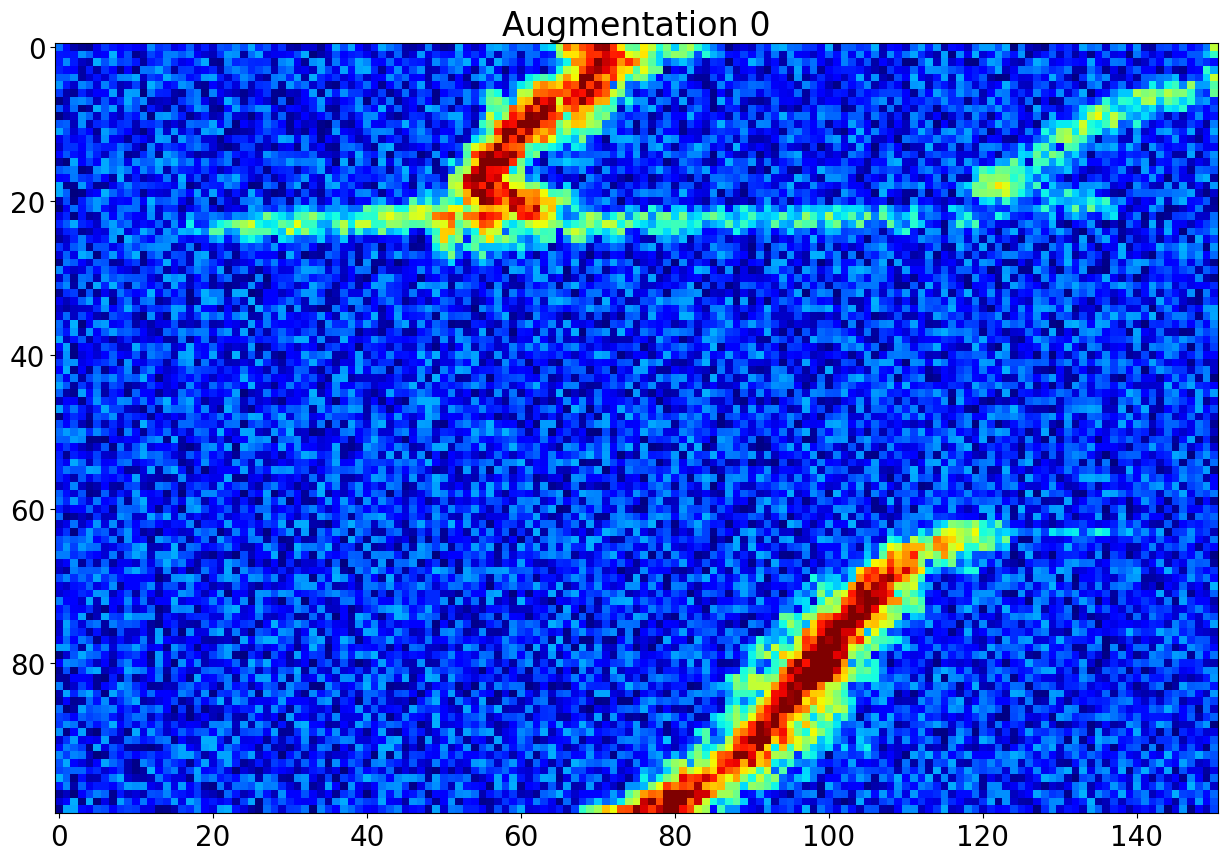

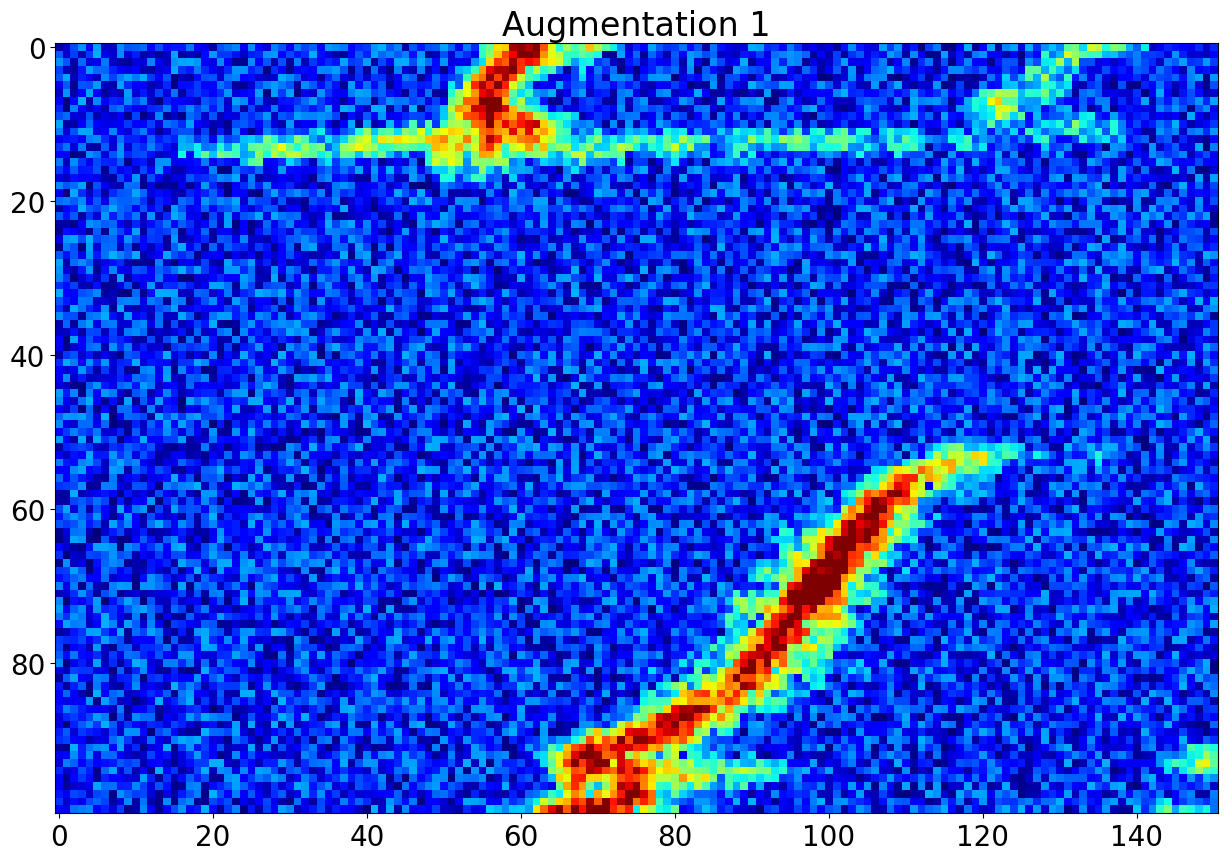

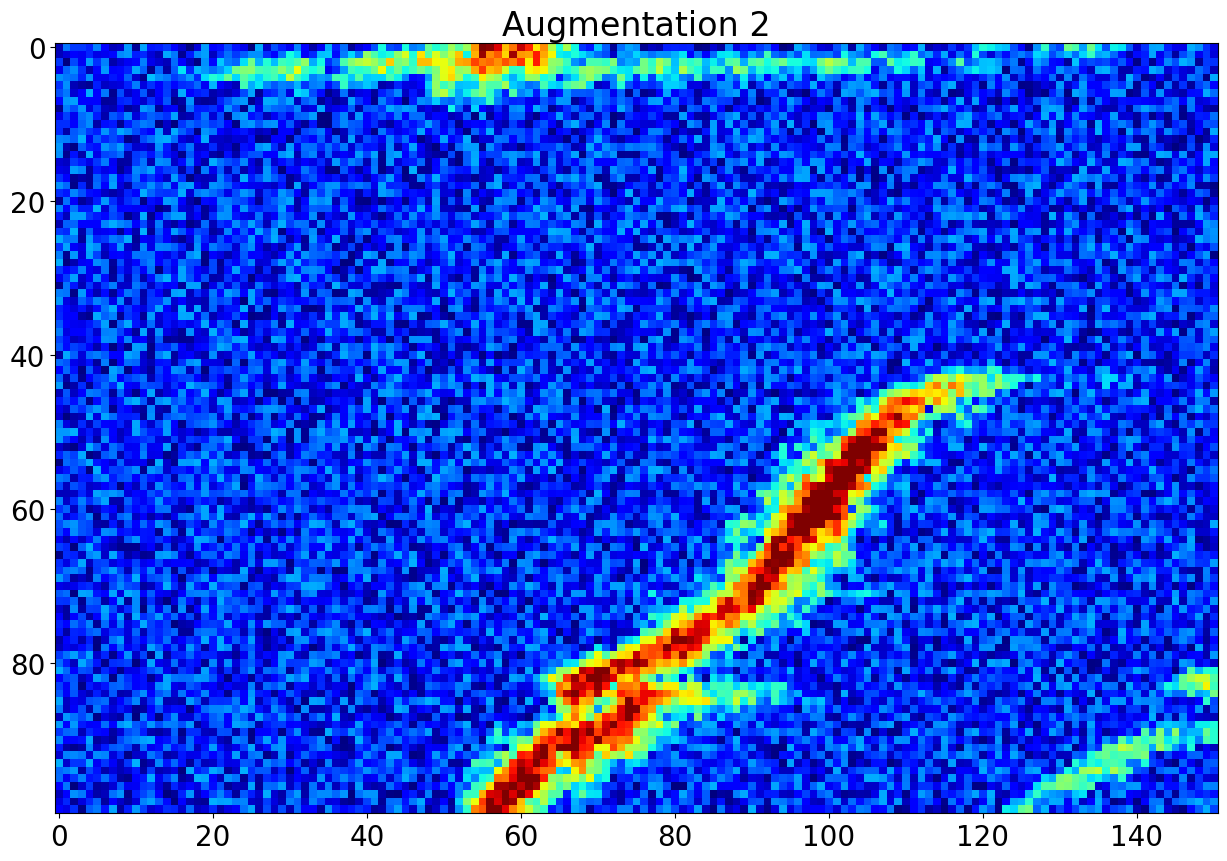

In [14]:
# =============================================================================
#     # Create contrastive dataloaders
# =============================================================================

augmentation_object = Temporal_Augmentation(simple_tweetyclr.dict_of_spec_slices_with_slice_number , simple_tweetyclr, tau_in_steps=tau_in_steps)

custom_transformation = TwoCropTransform(augmentation_object)

# # Your new_contrastive_dataset initialization would be:
new_contrastive_dataset = Custom_Contrastive_Dataset(stacked_windows_train, train_indices, custom_transformation)

# # DataLoader remains the same
contrastive_loader = torch.utils.data.DataLoader(new_contrastive_dataset, batch_size=batch_size, shuffle=False)

# Let's plot one anchor slice with its two positive augmentations
a = next(iter(contrastive_loader))
for i in np.arange(tau_in_steps):
    plt.figure()
    plt.imshow(a[0][i][0].clone().detach().numpy().squeeze(), cmap = 'jet')
    plt.title(f'Augmentation {i}')
    plt.show()


In [15]:
# =============================================================================
#     # Let's do some local saving to save on computational time
# =============================================================================

aug_tensor = torch.empty((tau_in_steps, 0, 1, simple_tweetyclr.window_size, 151))

# first_aug_tensor = torch.empty((0, 1, simple_tweetyclr.window_size, 151))
# second_aug_tensor = torch.empty((0, 1, simple_tweetyclr.window_size, 151))
labels_tensor = torch.empty((0))

aug_dict = {}

# Iterate through a range of 15 keys
for i in range(tau_in_steps):
    value = []  # Initialize an empty list as the value for each key
    aug_dict[i] = value

# aug_list = []
labels_list = []
batch_sizes = []

for batch_idx, (data, labels) in enumerate(contrastive_loader):
    labels_list.append(labels)
    
    for i in np.arange(len(data)):
        aug = data[i]
        # aug_tensor[i,:,:,:] = aug
        aug_dict[i].append(aug)
    
labels_tensor = torch.cat(labels_list, dim=0)

flattened_dict = {key: [item for sublist in value for item in sublist] for key, value in aug_dict.items()}

# Initialize a list to store the dictionaries
dataloader_list = []
# filepath_list = []



for i in np.arange(len(flattened_dict)):
    
    aug_data = torch.cat(flattened_dict[i], dim = 0)
    dataset = TensorDataset(aug_data, labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    dataloader_list.append(dataloader)


## Modeling

First model: Raw UMAP as a base unsupervised model

In [16]:
# =============================================================================
#     # UMAP on data_for_analysis as a base unsupervised model
# =============================================================================

# Memory issues when I try running UMAP on the raw spectrograms. I ran the umap analysis in colab with a random_state of 295 and a metric of cosine

data_tensor = torch.cat([batch[0] for batch in total_dataloader])

# # Raw UMAP on the original spectrogram slices

# reducer = umap.UMAP(metric = 'cosine', random_state = 295)

a = data_tensor.reshape(data_tensor.shape[0], data_tensor.shape[2]*data_tensor.shape[3]).clone().detach().numpy()
# embed = reducer.fit_transform(a)


I ran into memory issues so I will save the created data structures and run them on colab. On my Lambda machine this is not an issue.

In [ ]:
np.save('/Users/AnanyaKapoor/Downloads/stacked_windows.npy', a)

In [17]:
embed = np.load(f'{simple_tweetyclr.folder_name}/raw_umap_embedding.npy')

Create a colormap. Before I would colorize by the mean pixel-timecolor per spectrogram slice. Now I will colorize by slice index in the dataset. TBD on whether this is a good way to colorize the dataset.

In [18]:
# I want my mean_colors_per_minispec to be colorized by time
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

# Generate hues based on row number
hues = np.linspace(0, 1, embed.shape[0], endpoint=False)

# Create an HSV array (saturation and value are both set to 1)
hsv_colors = np.column_stack((hues, np.ones_like(hues), np.ones_like(hues)))

# Convert HSV to RGB
mean_colors_per_minispec = mcolors.hsv_to_rgb(hsv_colors)

In [19]:
simple_tweetyclr.mean_colors_per_minispec = mean_colors_per_minispec

/var/folders/yc/xlhlnm0n2bs9jrxbbrtxyt2h0000gv/T/ipykernel_18189/1134461730.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(0, embed.shape[0], num=5))  # Adjust ticks if needed


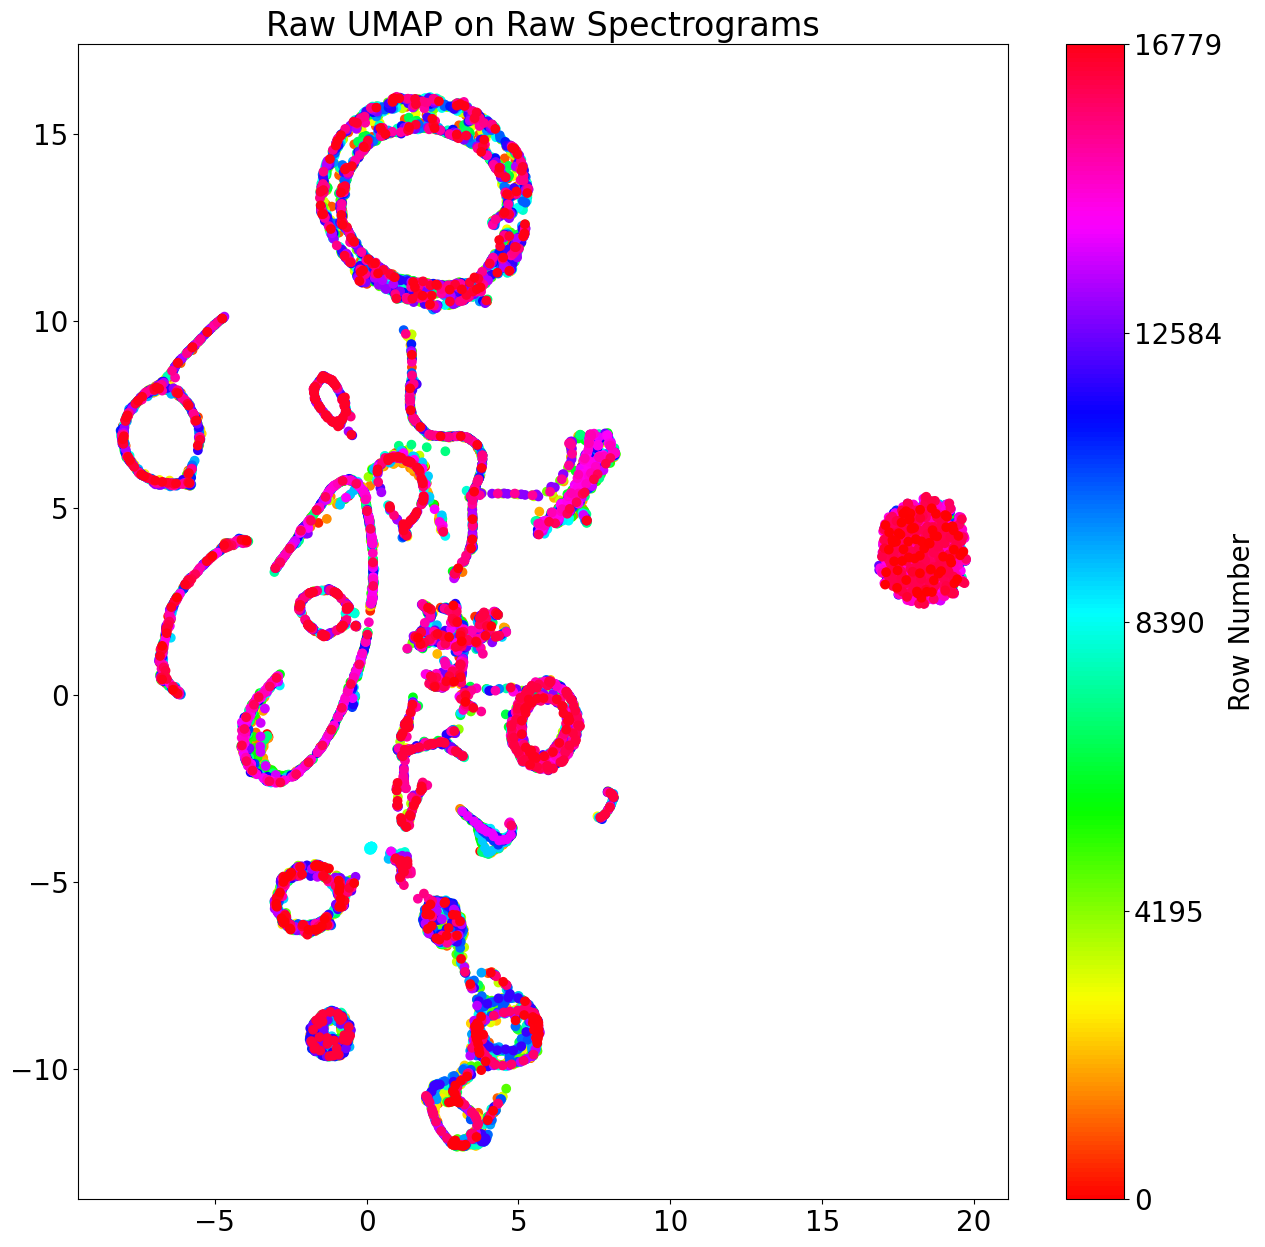

In [22]:
# =============================================================================
#     # UMAP on data_for_analysis as a base unsupervised model
# =============================================================================

# Memory issues when I try running UMAP on the raw spectrograms. I ran the umap analysis in colab with a random_state of 295 and a metric of cosine

# data_tensor = torch.cat([batch[0] for batch in total_dataloader])

# # Raw UMAP on the original spectrogram slices

# reducer = umap.UMAP(metric = 'cosine', random_state = 295)

# a = data_tensor.reshape(data_tensor.shape[0], data_tensor.shape[2]*data_tensor.shape[3]).clone().detach().numpy()
# embed = reducer.fit_transform(a)

simple_tweetyclr.init_umap_embed = embed

plt.figure()
plt.title("Raw UMAP on Raw Spectrograms")
plt.scatter(embed[:,0], embed[:,1], c = simple_tweetyclr.mean_colors_per_minispec)

# Create a ScalarMappable and initialize a normalization
# (In this case, from 0 to k, corresponding to your number of rows)
sm = ScalarMappable(cmap='hsv', norm=plt.Normalize(0, embed.shape[0]))
sm.set_array([])  # Only needed for older versions of matplotlib

# Add the color bar using the ScalarMappable
cbar = plt.colorbar(sm, ticks=np.linspace(0, embed.shape[0], num=5))  # Adjust ticks if needed
cbar.set_label('Row Number')

plt.savefig(f'{simple_tweetyclr.folder_name}/Plots/UMAP_of_raw_spectrograms.png')
plt.show()

simple_tweetyclr.plot_UMAP_embedding(embed, simple_tweetyclr.mean_colors_per_minispec, embeddable_images, f'{simple_tweetyclr.folder_name}/Plots/UMAP_of_raw_spectrograms.html', saveflag = True)


In [23]:
# =============================================================================
#     # Pass data through untrained model and extract representation
# =============================================================================

# Untrained Model Representation
# Ensure the model is on the desired device
model = Encoder().to(torch.float32).to(device)
# if torch.cuda.is_available():
#     model = model.cuda()
    # criterion = criterion.cuda()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)  # Using weight decay with AdamW
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

model = model.to('cpu')
model.eval()

# Initialize lists to store features and labels
model_rep_list_untrained = []

# Iterate over the DataLoaders
with torch.no_grad():  # Disable gradient computation for efficiency
    # for data_loader in dataloader_list:
    for batch_idx, (data) in enumerate(total_dataloader):
        data = data[0].to(torch.float32)
        features = model(data)
        model_rep_list_untrained.append(features)

# Convert lists to tensors
model_rep_untrained = torch.cat(model_rep_list_untrained, dim=0)



In [ ]:
np.save('/Users/AnanyaKapoor/Downloads/model_rep_untrained.npy', model_rep_untrained)

In [ ]:
embed = np.load(f'{simple_tweetyclr.folder_name}/untrained_rep_umap.npy')

In [ ]:
# #  UMAP on the untrained model
# reducer = umap.UMAP(metric = 'cosine', random_state = 295)

# a = model_rep_untrained.clone().detach().numpy()
# embed = reducer.fit_transform(a)
# simple_tweetyclr.untrained_rep_umap = embed


In [ ]:
plt.figure()
plt.title("Data UMAP Representation Through the Untrained Model")
plt.scatter(embed[:,0], embed[:,1], c = mean_colors_per_minispec)

# Create a ScalarMappable and initialize a normalization
# (In this case, from 0 to k, corresponding to your number of rows)
sm = ScalarMappable(cmap='hsv', norm=plt.Normalize(0, embed.shape[0]))
sm.set_array([])  # Only needed for older versions of matplotlib

# Add the color bar using the ScalarMappable
cbar = plt.colorbar(sm, ticks=np.linspace(0, embed.shape[0], num=5))  # Adjust ticks if needed
cbar.set_label('Row Number')

plt.savefig(f'{simple_tweetyclr.folder_name}/Plots/UMAP_of_untrained_model.png')

plt.show()

simple_tweetyclr.plot_UMAP_embedding(embed, mean_colors_per_minispec,embeddable_images, f'{simple_tweetyclr.folder_name}/Plots/UMAP_of_untrained_model.html', saveflag = True)


[Epoch: 000] Contrastive Pre-train | Loss: 0.7677 | Learning Rate: 0.0010
0.9702380952380952


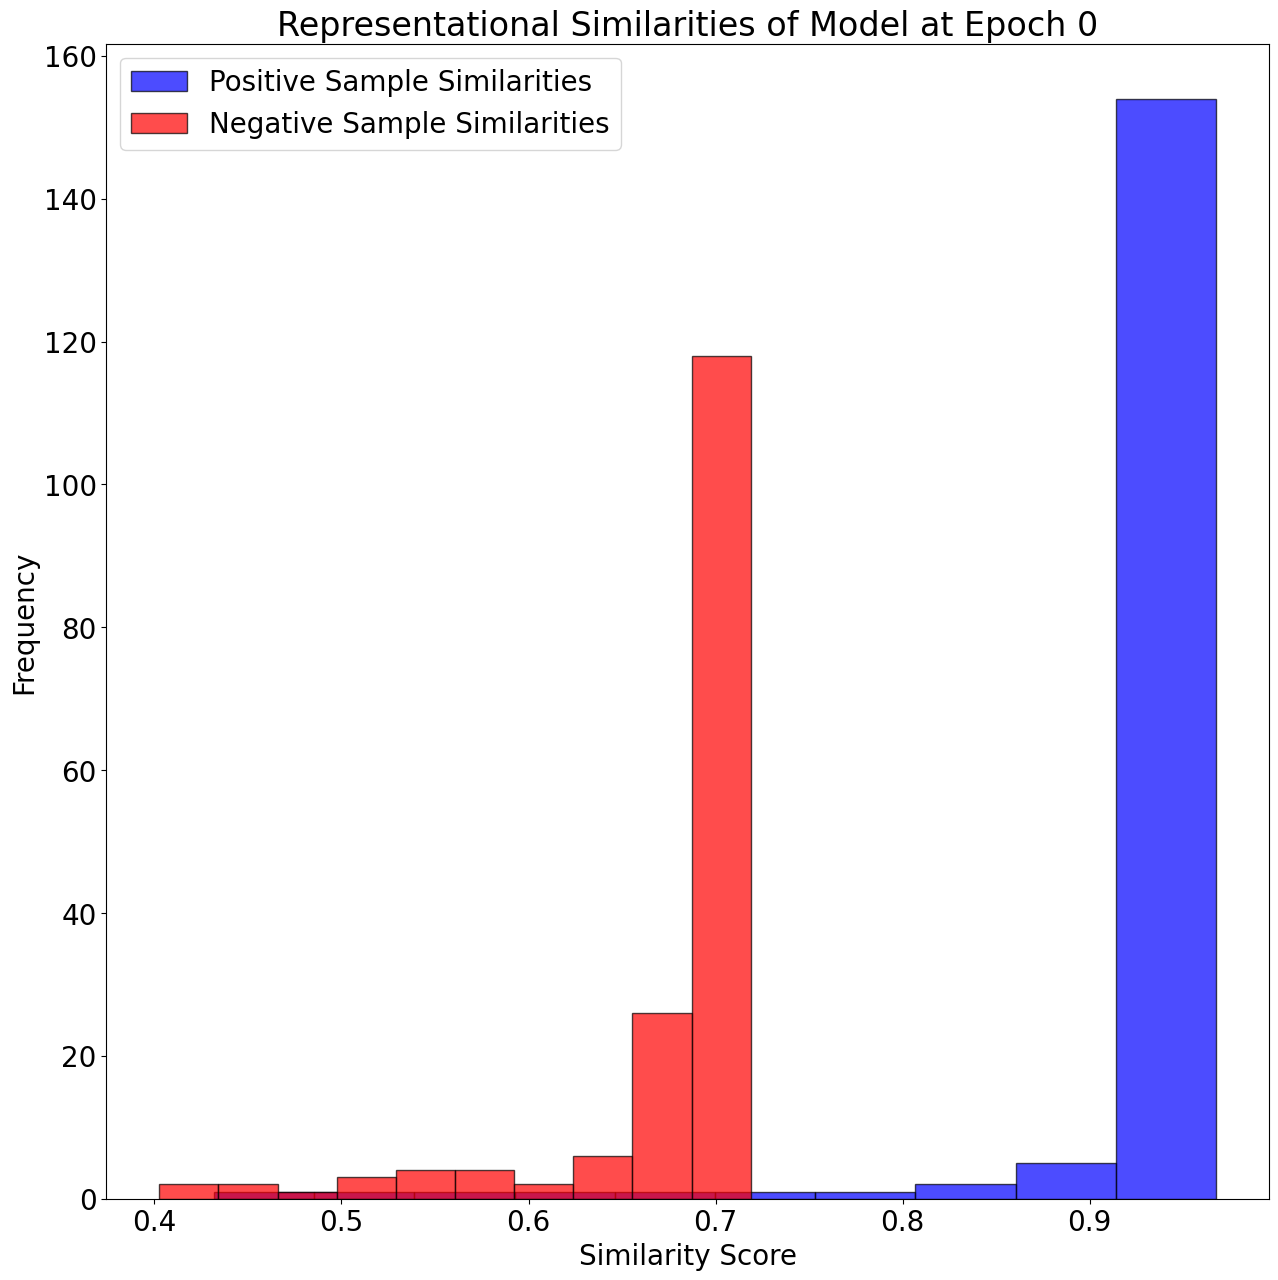

[Epoch: 001] Contrastive Pre-train | Loss: 0.6056 | Learning Rate: 0.0010
1.0


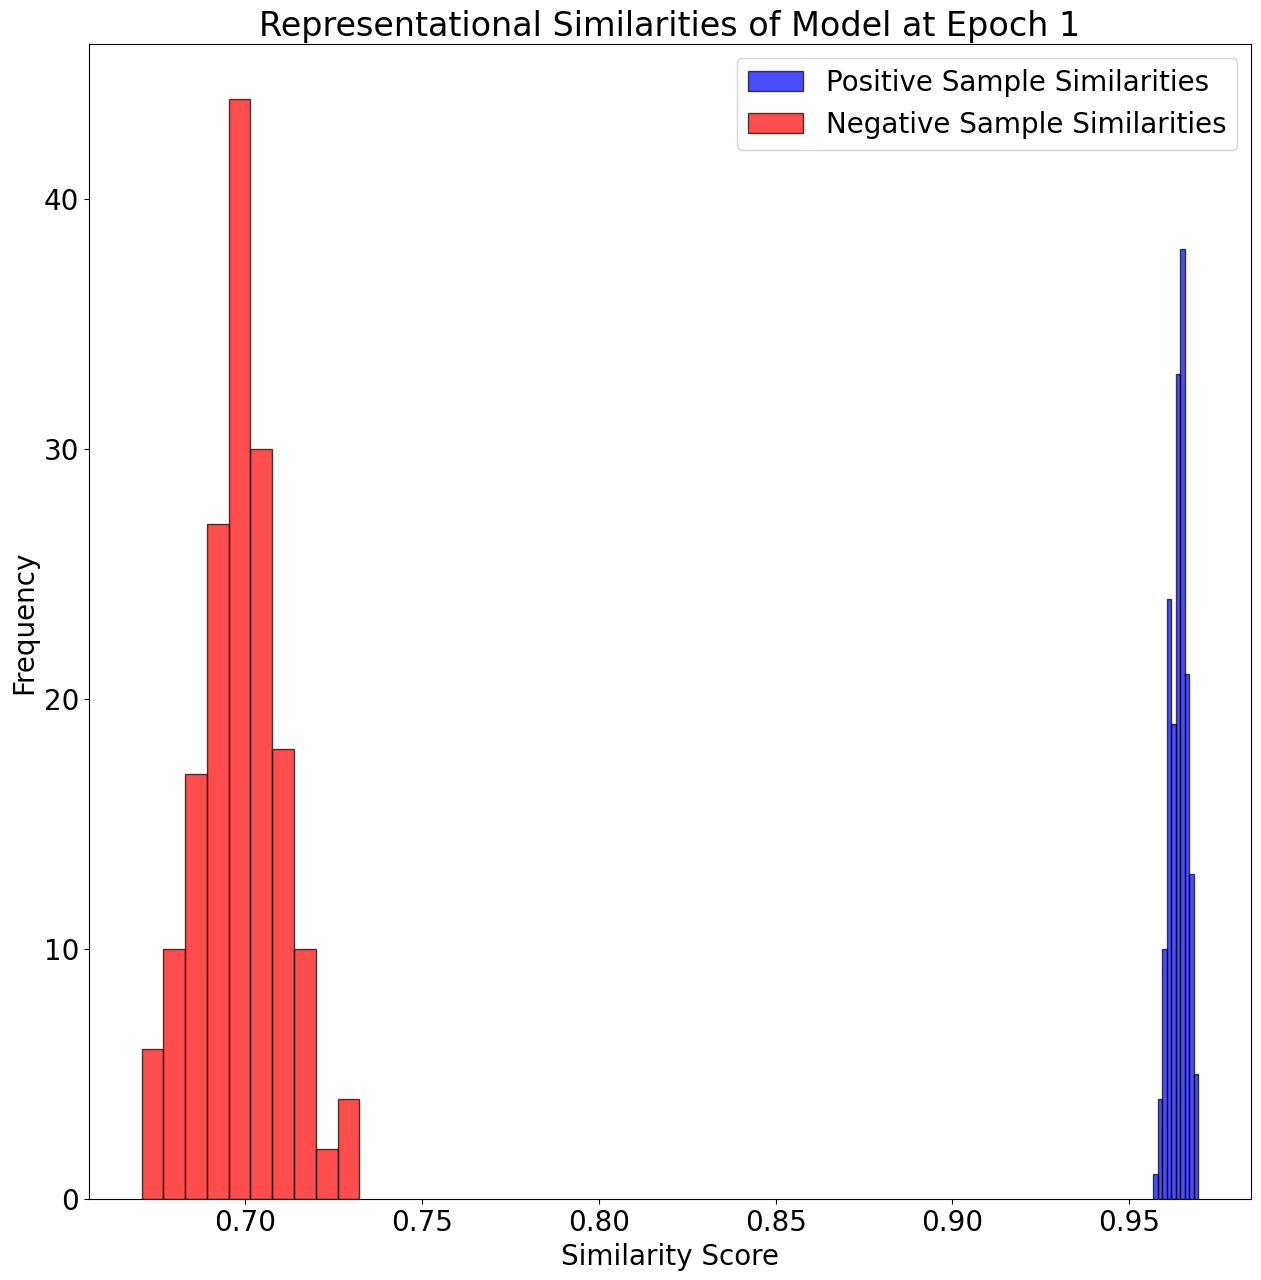

[Epoch: 002] Contrastive Pre-train | Loss: 0.5800 | Learning Rate: 0.0010
1.0


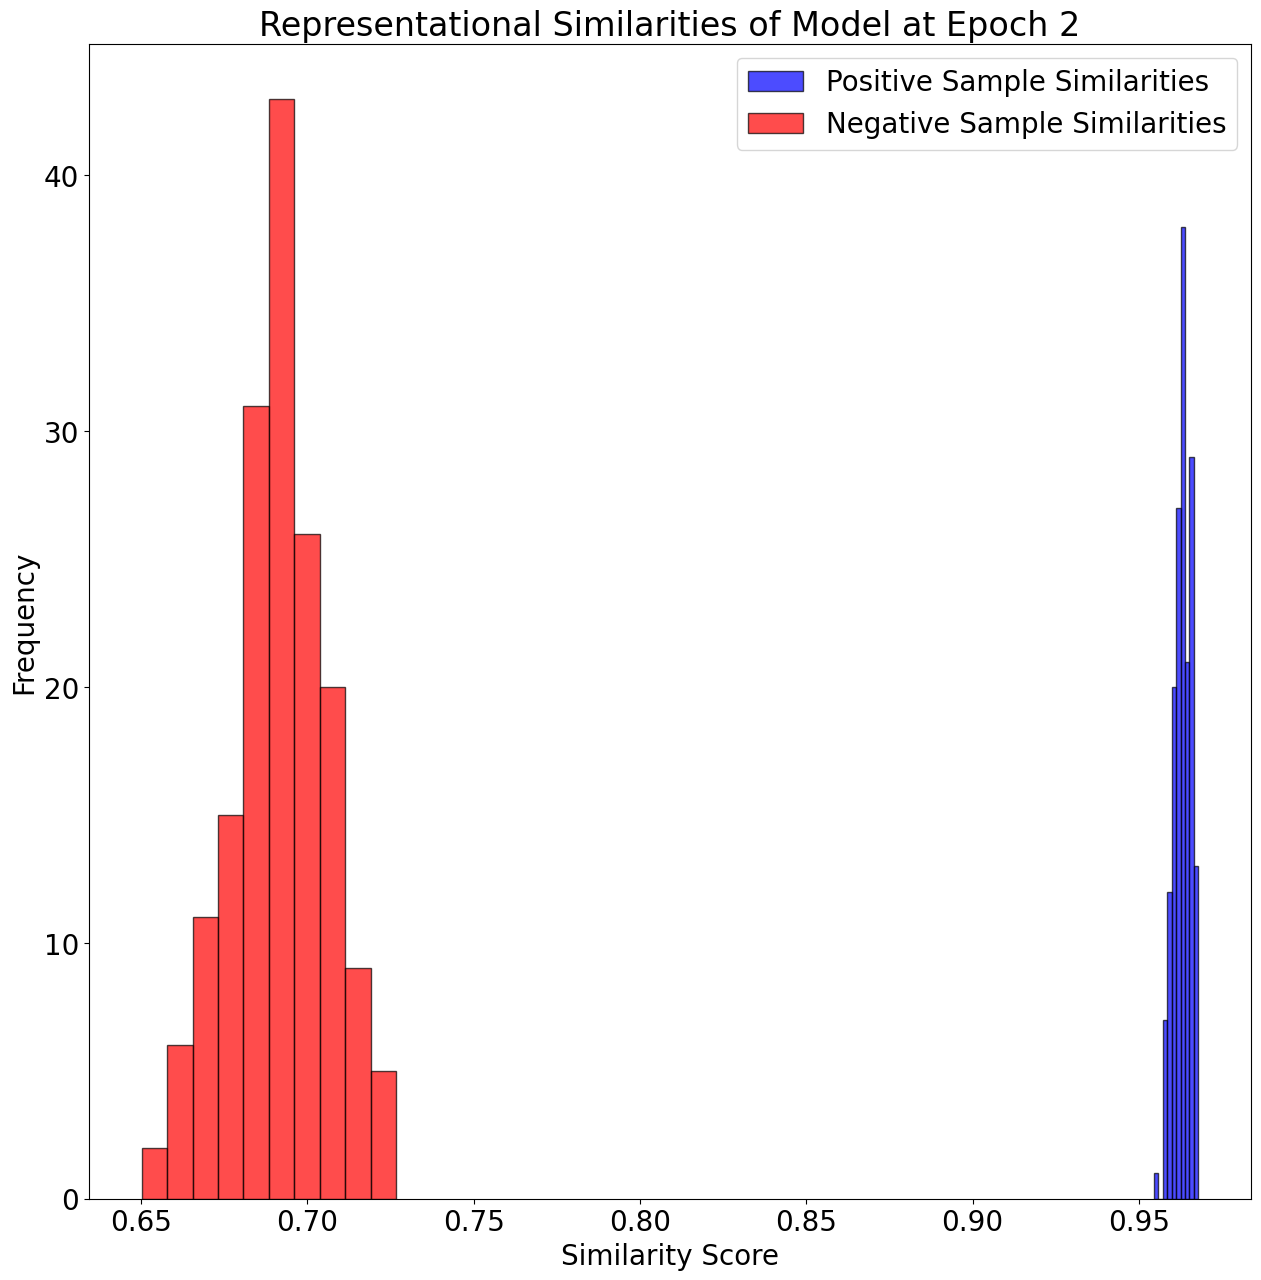

[Epoch: 003] Contrastive Pre-train | Loss: 0.5679 | Learning Rate: 0.0010
1.0


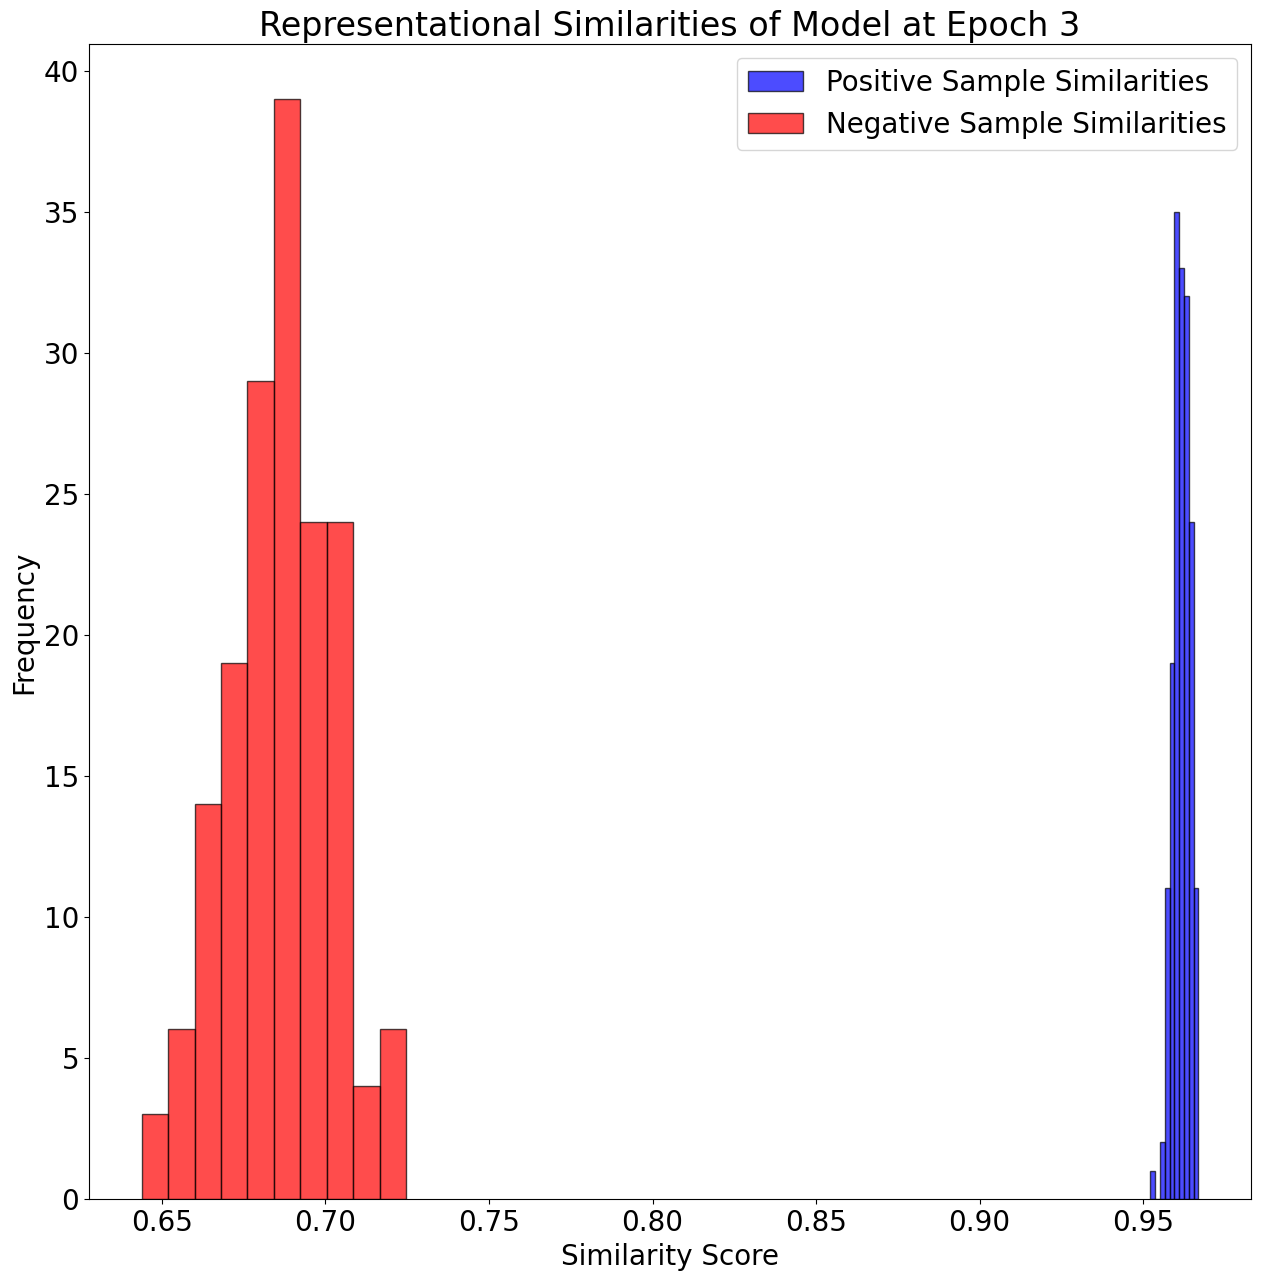

[Epoch: 004] Contrastive Pre-train | Loss: 0.5608 | Learning Rate: 0.0010
1.0


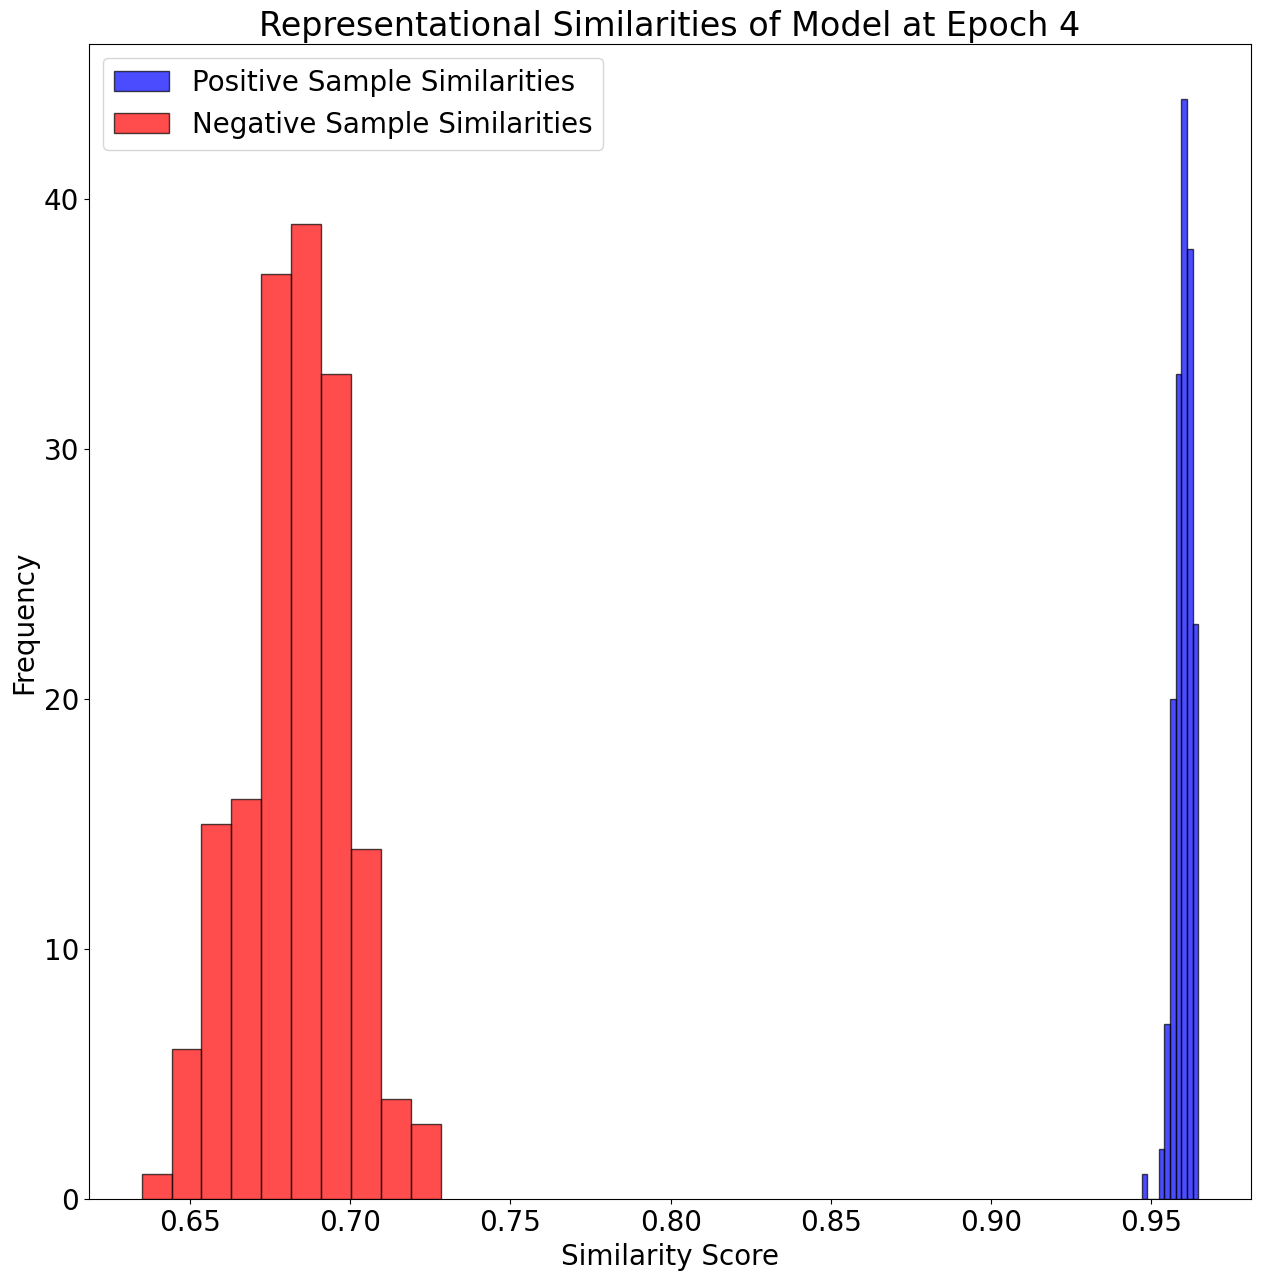

[Epoch: 005] Contrastive Pre-train | Loss: 0.5558 | Learning Rate: 0.0010
1.0


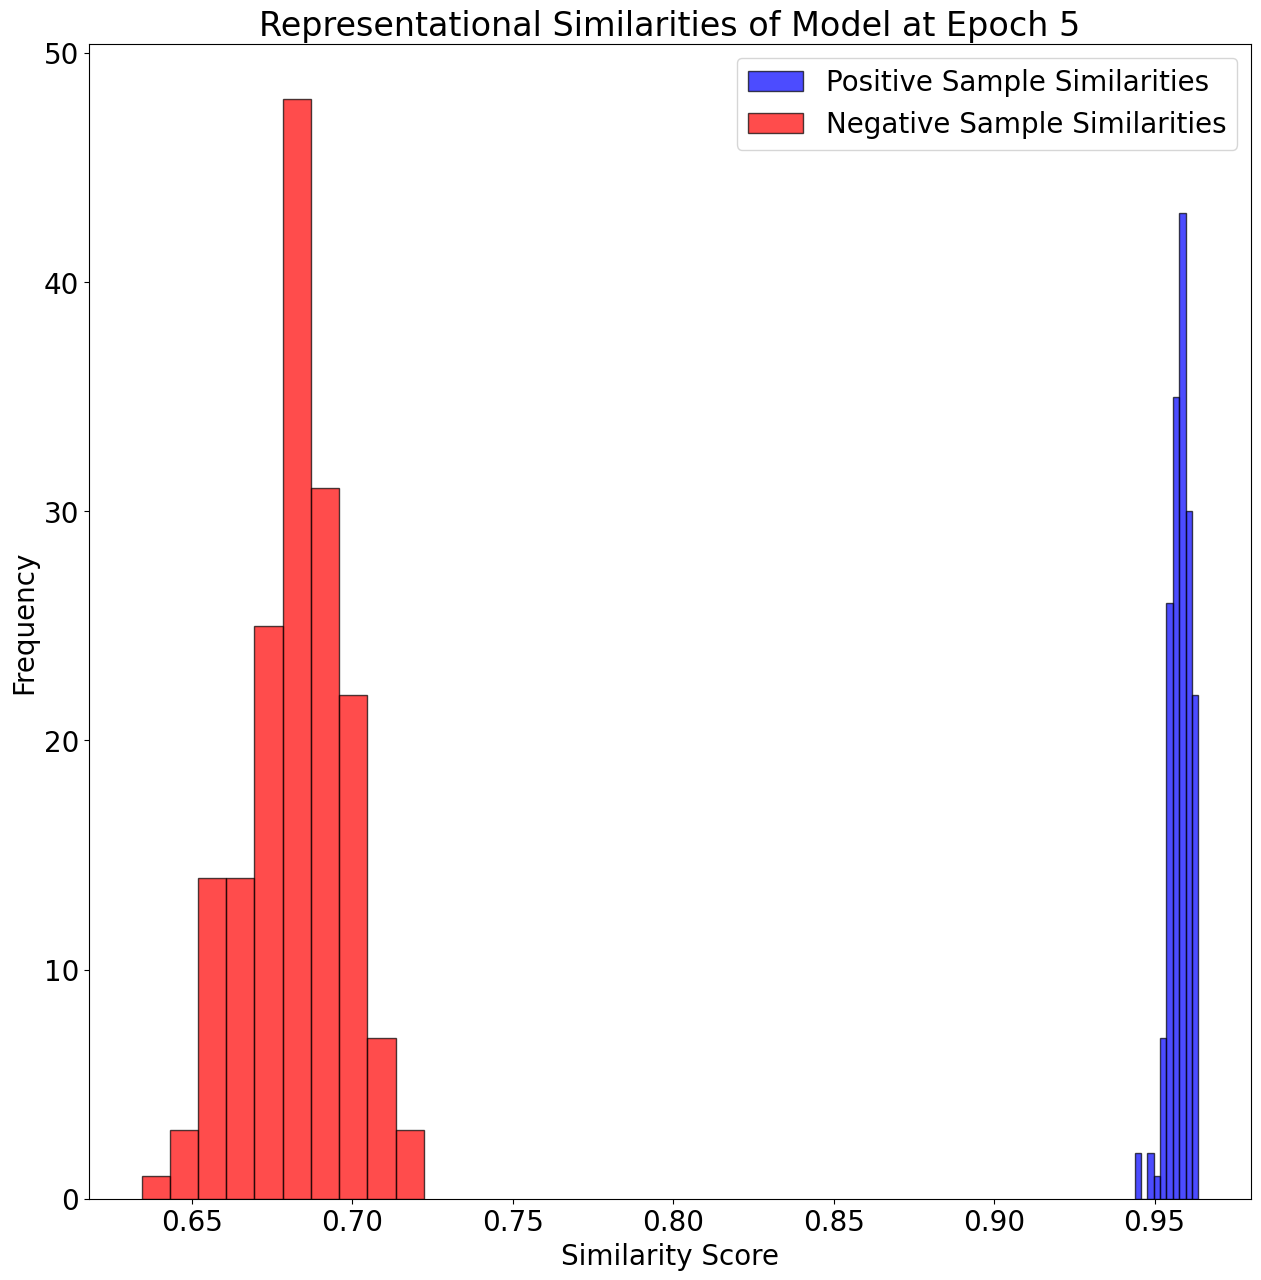

[Epoch: 006] Contrastive Pre-train | Loss: 0.5518 | Learning Rate: 0.0010
1.0


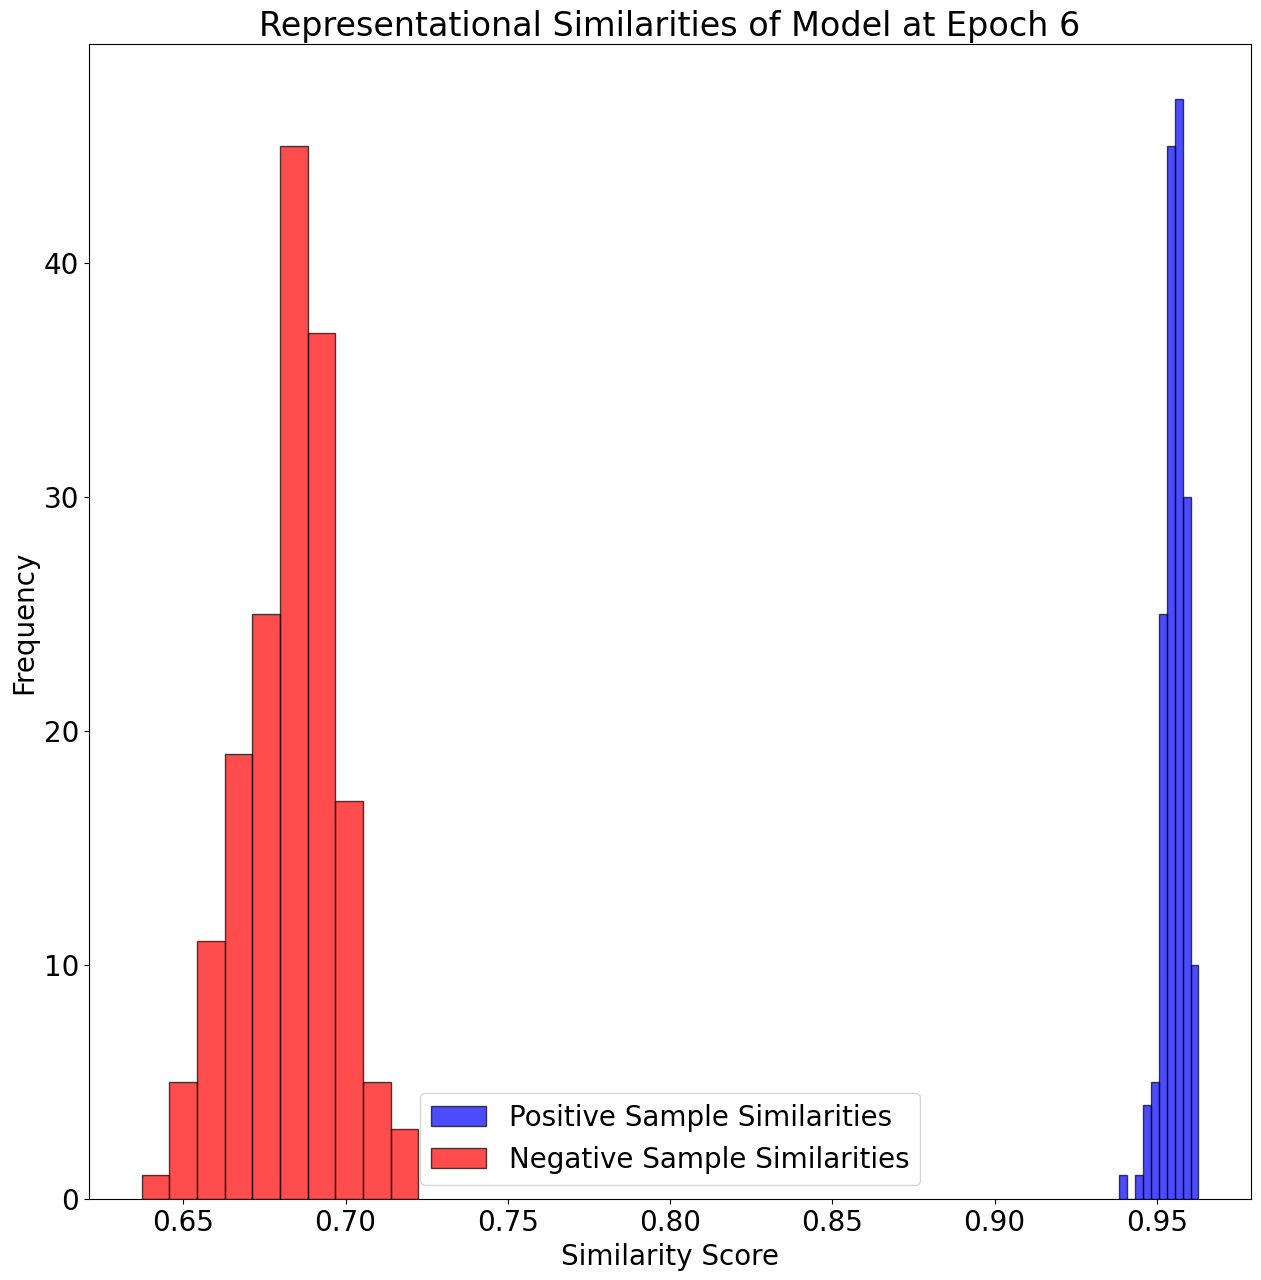

KeyboardInterrupt: 

In [24]:
# =============================================================================
#     # Train the model! Extract the model representation
# =============================================================================

contrastive_loss, contrastive_lr = [], []

# Store the negative sample similarities and positive sample similarities at each epoch.
negative_sims_epoch = [] 
positive_sims_epoch = []

model = model.to(device)
model.train()

intermediate_reps = [] # I want to store each epoch's model representation. I will then apply UMAP to each of these representations
# to see how much the UMAP representations change from epoch to epoch.

for epoch in range(0, num_epochs+1):

    criterion = SupConLoss(temperature=temp_value)
    loss, lr, features, neg_sims, pos_sims = pretraining(epoch, model, zip(*dataloader_list), optimizer, criterion, method=method)

    negative_sims_epoch.append(neg_sims)
    positive_sims_epoch.append(pos_sims)

    if (use_scheduler == True) & (epoch !=0):
        scheduler.step()

    contrastive_loss.append(loss)
    contrastive_lr.append(lr)

    if epoch%1 == 0:
        torch.save(model.state_dict(), f'{simple_tweetyclr.folder_name}/_model_state_epoch_{epoch}_dict.pth')

    # Just for now (debugging purposes), I want to get each epoch's UMAP representation. Will give insight into whether learning is occurring
    model = model.to('cpu')
    model.eval()

    # Initialize lists to store features and labels
    model_rep_list_trained = []

    # Iterate over the DataLoaders
    with torch.no_grad():  # Disable gradient computation for efficiency
        # for data_loader in dataloader_list:
        for batch_idx, (data) in enumerate(total_dataloader):
            data = data[0].to(torch.float32)
            features = model(data)
            model_rep_list_trained.append(features)

    # Convert lists to tensors
    model_rep_trained = torch.cat(model_rep_list_trained, dim=0)

    intermediate_reps.append(model_rep_trained)

    # UNTRAINED 

    plt.figure()
    plt.hist([num * temp_value for num in positive_sims_epoch[epoch]], alpha = 0.7, edgecolor = 'black', color = 'blue', label = 'Positive Sample Similarities')
    plt.hist([num * temp_value for num in negative_sims_epoch[epoch]], alpha = 0.7, edgecolor = 'black', color = 'red', label = 'Negative Sample Similarities')
    plt.legend()
    from scipy.stats import ks_2samp

    ks, p = ks_2samp([num * temp_value for num in positive_sims_epoch[epoch]], [num * temp_value for num in negative_sims_epoch[epoch]])
    print(ks)
    plt.title(f'Representational Similarities of Model at Epoch {epoch}')
    # plt.title(f'KS Value: {ks:.3f}')
    plt.xlabel('Similarity Score')
    plt.ylabel("Frequency")
    plt.show()

Extract the final epoch model representation

In [25]:
np.save(f'{simple_tweetyclr.folder_name}/model_rep_trained_final_epoch.npy', intermediate_reps[-1])

In [26]:
trained_rep_umap = np.load(f'{simple_tweetyclr.folder_name}/trained_rep_umap.npy')

/var/folders/yc/xlhlnm0n2bs9jrxbbrtxyt2h0000gv/T/ipykernel_18189/216619786.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(0, trained_rep_umap.shape[0], num=5))  # Adjust ticks if needed


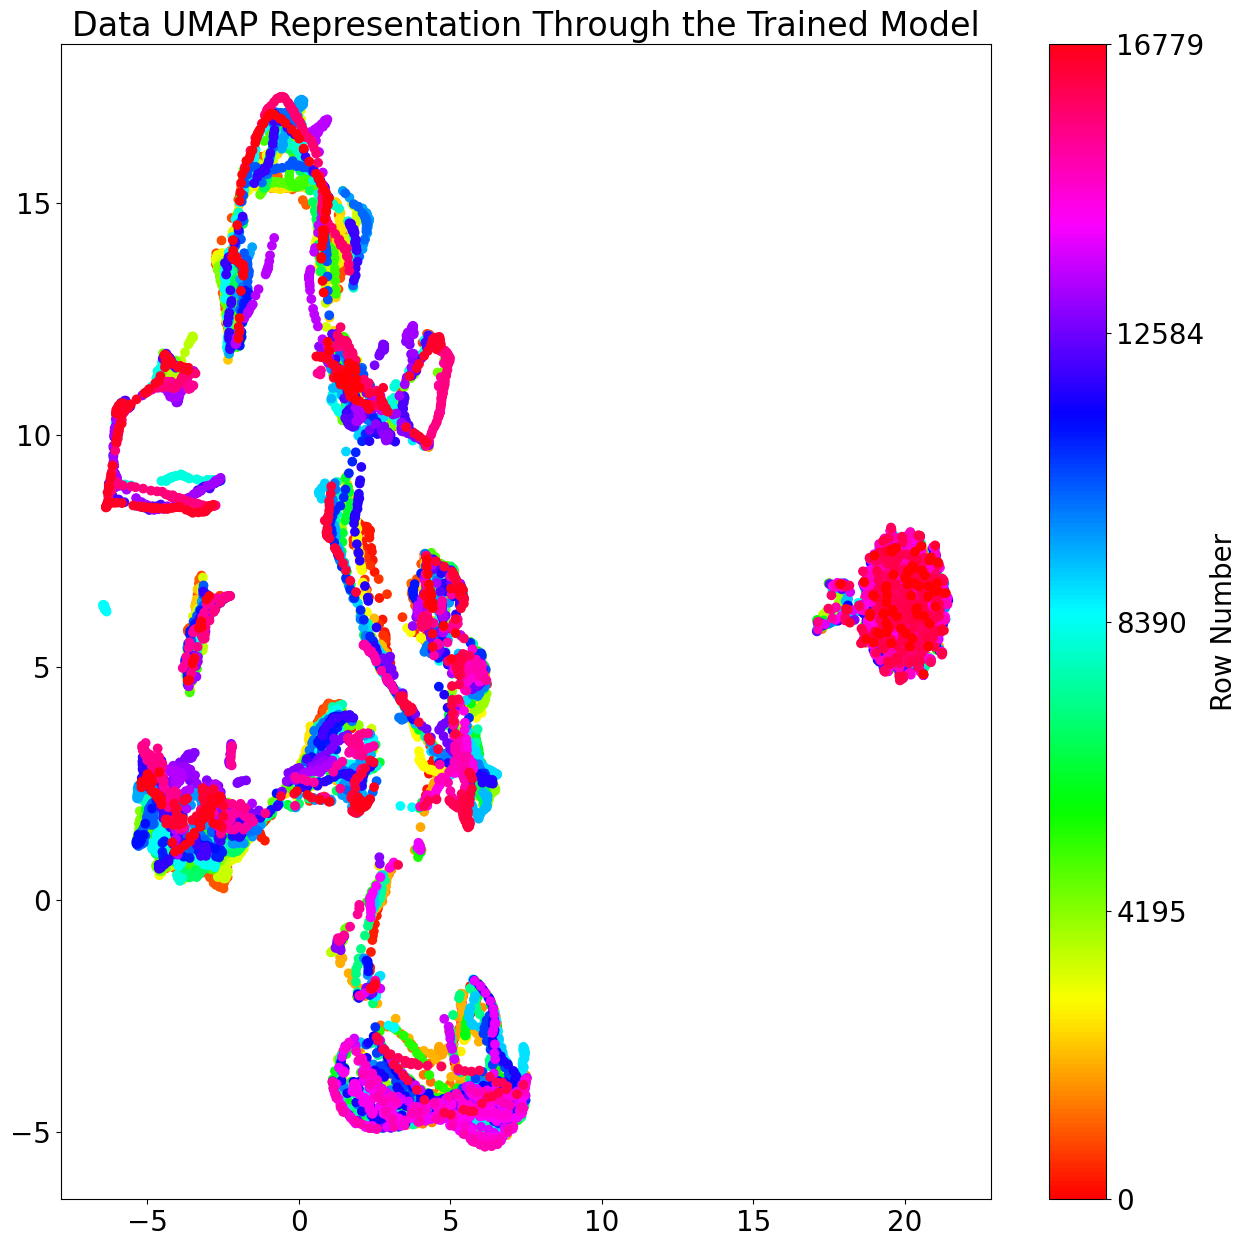

In [27]:
plt.figure()
plt.title("Data UMAP Representation Through the Trained Model")
plt.scatter(trained_rep_umap[:,0], trained_rep_umap[:,1], c = simple_tweetyclr.mean_colors_per_minispec)

# Create a ScalarMappable and initialize a normalization
# (In this case, from 0 to k, corresponding to your number of rows)
sm = ScalarMappable(cmap='hsv', norm=plt.Normalize(0, trained_rep_umap.shape[0]))
sm.set_array([])  # Only needed for older versions of matplotlib

# Add the color bar using the ScalarMappable
cbar = plt.colorbar(sm, ticks=np.linspace(0, trained_rep_umap.shape[0], num=5))  # Adjust ticks if needed
cbar.set_label('Row Number')

plt.savefig(f'{simple_tweetyclr.folder_name}/Plots/UMAP_of_trained_model.png')

plt.show()

simple_tweetyclr.plot_UMAP_embedding(trained_rep_umap, mean_colors_per_minispec,embeddable_images, f'{simple_tweetyclr.folder_name}/Plots/UMAP_of_trained_model.html', saveflag = True)


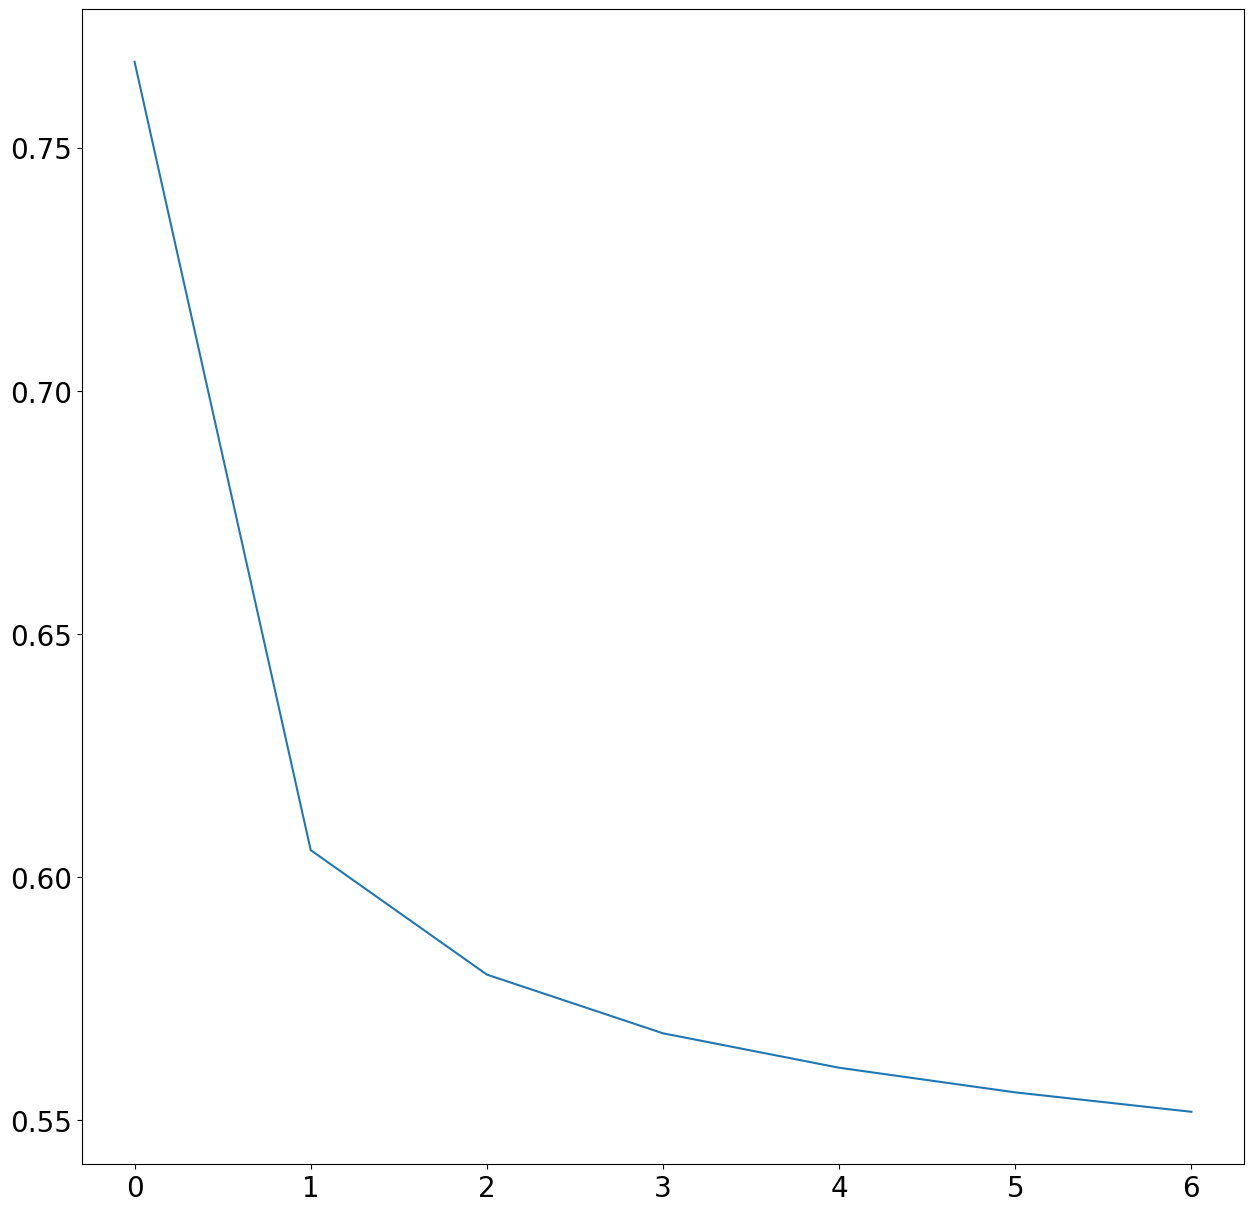

In [28]:
plt.figure()
plt.plot(contrastive_loss)

Set up data structures for Ethan's visualizer

In [29]:
embVals = trained_rep_umap.copy()
behavioralArr = simple_tweetyclr.stacked_specs
embStartEnd = np.zeros((2, simple_tweetyclr.stacked_window_times.shape[0]))

embStartEnd[0,:] = simple_tweetyclr.stacked_window_times[:,0]
embStartEnd[1,:] = simple_tweetyclr.stacked_window_times[:,-1]
total_dict = {}

total_dict['embStartEnd'] = embStartEnd
total_dict['embVals'] = embVals
total_dict['behavioralArr'] = behavioralArr


dat = np.savez(f'{simple_tweetyclr.folder_name}/total_dict_transection.npz', **total_dict)

In [30]:
simple_tweetyclr.negative_sims_epoch = negative_sims_epoch
simple_tweetyclr.positive_sims_epoch = positive_sims_epoch
simple_tweetyclr.contrastive_loss = contrastive_loss
simple_tweetyclr.intermediate_reps = intermediate_reps


In [31]:
# Save the object to file
with open(f'{simple_tweetyclr.folder_name}/simple_tweetyclr.pkl', 'wb') as file:  # 'wb' mode for writing in binary format
    pickle.dump(simple_tweetyclr, file)
